# Implementaci√≥n del Modelo SVM  

Como segundo modelo, hemos decidido implementar el **SVM con margen suave (Soft Margin)**.  
Este enfoque permite que el modelo maneje datos que no son perfectamente separables, 
introduciendo un par√°metro de regularizaci√≥n **C** que controla el equilibrio entre:  

- Maximizar el margen de separaci√≥n entre las clases.  
- Minimizar los errores de clasificaci√≥n en el conjunto de entrenamiento.  

De esta forma, el SVM con margen suave logra mayor **robustez frente al ruido y outliers**, 
lo que lo convierte en una alternativa m√°s adecuada para problemas reales donde los datos 
no siguen una separaci√≥n lineal perfecta.  


---

Este bloque de c√≥digo importa las librer√≠as necesarias para la implementaci√≥n y an√°lisis del modelo SVM.  
Se utilizan **pandas** y **numpy** para la manipulaci√≥n y procesamiento eficiente de datos en forma de tablas y matrices.  
La funci√≥n **product** de *itertools* permite generar todas las combinaciones posibles de hiperpar√°metros durante la b√∫squeda del mejor modelo.  

Para la visualizaci√≥n de resultados se emplea **matplotlib.pyplot** y **seaborn**, siendo esta √∫ltima √∫til para representar la matriz de confusi√≥n en forma de mapa de calor y obtener gr√°ficos m√°s estilizados.  

Del m√≥dulo **sklearn** se incorporan:  
- `train_test_split`, para dividir los datos en entrenamiento y validaci√≥n.  
- `StandardScaler`, para normalizar las variables de entrada, paso importante en algoritmos sensibles a la escala como el SVM.  

Adicionalmente, de **scipy.spatial.distance** se usa `cdist` para el c√°lculo de distancias entre conjuntos de puntos, √∫til en el c√°lculo de m√°rgenes y distancias.  

Finalmente, de **sklearn.metrics** se importa `confusion_matrix`, que permite evaluar el rendimiento del modelo a trav√©s de los valores de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.


In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from itertools import product

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Algoritmo de SVM
La clase **KernelSVM** implementa un modelo de *Support Vector Machine (SVM)* con soporte para diferentes funciones kernel.  
Su dise√±o permite entrenar y predecir tanto con un margen suave como con kernels no lineales (polinomial y RBF).  

### Componentes principales:

1. **Constructor `__init__`**  
   - Define los hiperpar√°metros del modelo:  
     - `C`: par√°metro de regularizaci√≥n que controla el margen y los errores de clasificaci√≥n.  
     - `kernel`: tipo de kernel a utilizar (`linear`, `poly`, `rbf`).  
     - `gamma`: coeficiente para el kernel RBF. Puede ser `'scale'`, `None`, o un valor num√©rico.  
     - `degree`: grado del polinomio si se usa kernel polinomial.  
     - `normalize`: indica si los datos de entrada deben ser normalizados con `StandardScaler`.  
     - `n_iters`: n√∫mero de iteraciones de entrenamiento.  
     - `verbose`: activa la visualizaci√≥n del progreso durante el entrenamiento.  
   - Inicializa tambi√©n par√°metros internos como los multiplicadores de Lagrange (`alpha`), el sesgo (`b`) y el escalador de datos (`scaler`).  


2. **M√©todo `_kernel_function`**  
   - Calcula la matriz kernel entre dos conjuntos de datos:  
     - **Lineal**: producto punto entre los vectores.  
     - **Polinomial**: \((X_1 \cdot X_2^T + 1)^{degree}\).  
     - **RBF (Radial Basis Function)**: utiliza la distancia euclidiana al cuadrado y el par√°metro `gamma` para calcular  
       \(\exp(-\gamma \cdot ||X_1 - X_2||^2)\).  
   - Permite flexibilidad al adaptarse al tipo de kernel definido por el usuario.  


3. **M√©todo `fit` (Entrenamiento)**  
   - **Normalizaci√≥n**: si est√° activada, aplica `StandardScaler` a los datos de entrada.  
   - **Transformaci√≥n de etiquetas**: convierte las clases a \(-1\) y \(+1\).  
   - **Inicializaci√≥n**: se crean los multiplicadores de Lagrange (`alpha`) y se calcula la matriz kernel \(K\).  
   - **Optimizaci√≥n**: en cada iteraci√≥n se actualizan los valores de `alpha` para maximizar el margen, aplicando una proyecci√≥n al rango \([0, C]\).  
   - **Sesgo (`b`)**: se recalcula como el promedio entre las diferencias de etiquetas y predicciones actuales.  
   - **Verbose**: si est√° activado, muestra la exactitud del modelo cada 100 iteraciones.  


4. **M√©todo `predict` (Predicci√≥n)**  
   - Normaliza los datos de entrada si se entren√≥ con normalizaci√≥n.  
   - Calcula el kernel entre las nuevas muestras y los datos de entrenamiento.  
   - Realiza la predicci√≥n aplicando:  
     \[
     \hat{y} = \text{sign}\left(\sum_i \alpha_i y_i K(x, x_i) + b \right)
     \]  
   - Devuelve la etiqueta predicha (\(-1\) o \(+1\)) para cada muestra.  


### En resumen:  
Esta clase implementa un **SVM kernelizado desde cero**, soportando kernels lineales, polinomiales y RBF.  
Incluye normalizaci√≥n opcional, optimizaci√≥n basada en actualizaciones iterativas de los multiplicadores de Lagrange, y permite visualizar el rendimiento durante el entrenamiento.


In [100]:
class KernelSVM:
    def __init__(self, C=1.0, kernel='rbf', gamma=None, degree=3, normalize=True, n_iters=1000, verbose=False):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.normalize = normalize
        self.n_iters = n_iters
        self.verbose = verbose
        
        self.alpha = None
        self.b = 0
        self.X_train = None
        self.y_train = None
        self.scaler = None
    
    # Kernel function
    def _kernel_function(self, X1, X2):
        if self.kernel == 'linear':
            return X1 @ X2.T
        elif self.kernel == 'poly':
            return (X1 @ X2.T + 1) ** self.degree
        elif self.kernel == 'rbf':
            # calcular gamma si es 'scale'
            if self.gamma == 'scale':
                gamma = 1.0 / (X1.shape[1] * X1.var())
            elif self.gamma is None:
                gamma = 1.0 / X1.shape[1]
            else:
                gamma = self.gamma
            dists = cdist(X1, X2, 'sqeuclidean')
            return np.exp(-gamma * dists)
        else:
            raise ValueError("Kernel no soportado")

    
    def fit(self, X, y):
        if self.normalize:
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)
        
        y = np.where(y <= 0, -1, 1)
        n_samples = X.shape[0]
        self.alpha = np.zeros(n_samples)
        self.X_train = X
        self.y_train = y
        
        K = self._kernel_function(X, X)
        
        for it in range(self.n_iters):
            for i in range(n_samples):
                u = np.sum(self.alpha * y * K[:, i]) + self.b
                gradient = 1 - y[i] * u
                if gradient > 0:
                    self.alpha[i] += self.C * gradient / (K[i, i] + 1e-12)
                    self.alpha[i] = max(0, min(self.C, self.alpha[i]))
            self.b = np.mean(y - (self.alpha * y) @ K)
            
            if self.verbose and (it + 1) % 100 == 0:
                y_pred = self.predict(X)
                acc = np.mean(y_pred == y)
                print(f"Iter {it+1}/{self.n_iters} - Accuracy: {acc:.4f}")
    
    def predict(self, X):
        if self.normalize and self.scaler is not None:
            X = self.scaler.transform(X)
        K_test = self._kernel_function(X, self.X_train)
        y_pred = np.sign(np.sum(self.alpha * self.y_train * K_test, axis=1) + self.b)
        return y_pred

## Funciones para las m√©tricas 

Este bloque de c√≥digo implementa funciones para evaluar el rendimiento del modelo **SVM** mediante m√©tricas cl√°sicas de clasificaci√≥n.  
Cada funci√≥n est√° construida sobre una matriz de confusi√≥n adaptada al formato de etiquetas \(-1\) y \(+1\).  


### 1. `confusion_matrix_SVM(y_true, y_pred)`  
- Calcula manualmente la **matriz de confusi√≥n** a partir de las etiquetas reales y predichas.  
- Elementos:  
  - **TP (True Positives)**: predicciones correctas de la clase positiva (+1).  
  - **TN (True Negatives)**: predicciones correctas de la clase negativa (‚àí1).  
  - **FP (False Positives)**: instancias negativas mal clasificadas como positivas.  
  - **FN (False Negatives)**: instancias positivas mal clasificadas como negativas.  
- Devuelve una matriz \(2 \times 2\):  
  \[
  \begin{bmatrix}
  TN & FP \\
  FN & TP
  \end{bmatrix}
  \]



### 2. `precision_SVM(y_true, y_pred)`  
- Calcula la **precisi√≥n**, que mide qu√© proporci√≥n de las predicciones positivas son realmente correctas:  
\[
\text{Precision} = \frac{TP}{TP + FP}
\]  
- Se a√±ade un peque√±o valor \(1e-9\) en el denominador para evitar divisiones por cero.


### 3. `recall_SVM(y_true, y_pred)`  
- Calcula el **recall** o sensibilidad, que mide qu√© proporci√≥n de las instancias positivas fueron correctamente identificadas:  
\[
\text{Recall} = \frac{TP}{TP + FN}
\]  
- Tambi√©n usa \(1e-9\) para evitar divisiones por cero.


### 4. `f1_score_SVM(y_true, y_pred)`  
- Combina **precisi√≥n** y **recall** en una m√©trica balanceada, el **F1-Score**:  
\[
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\]  
- Es √∫til cuando se busca un equilibrio entre minimizar falsos positivos y falsos negativos.


### En resumen:
Estas funciones permiten evaluar el modelo **SVM** en clasificaci√≥n binaria con etiquetas \(-1, +1\), proporcionando m√©tricas clave:
- **Matriz de confusi√≥n**
- **Precisi√≥n**
- **Recall**
- **F1-Score**  
Todo implementado desde cero para mayor control y personalizaci√≥n en la evaluaci√≥n del modelo.


In [101]:
def confusion_matrix_SVM(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == -1) & (y_pred == -1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == -1))
    return np.array([[tn, fp],[fn, tp]])

def precision_SVM(y_true, y_pred):
    cm = confusion_matrix_SVM(y_true, y_pred)
    tp = cm[1,1]
    fp = cm[0,1]
    return tp / (tp + fp + 1e-9)

def recall_SVM(y_true, y_pred):
    cm = confusion_matrix_SVM(y_true, y_pred)
    tp = cm[1,1]
    fn = cm[1,0]
    return tp / (tp + fn + 1e-9)

def f1_score_SVM(y_true, y_pred):
    p = precision_SVM(y_true, y_pred)
    r = recall_SVM(y_true, y_pred)
    return 2 * (p * r) / (p + r + 1e-9)



## Funci√≥n para hallar mejores Hiperpar√°metros

Esta funci√≥n implementa una **b√∫squeda de hiperpar√°metros** para el modelo **Linear SVM** mediante un enfoque de fuerza bruta (grid search), evaluando todas las combinaciones posibles de par√°metros definidos.


### `hyperparameter_search_SVM(X_train, y_train, X_val, y_val, lr_list, lambda_list, iter_list)`

#### **Par√°metros de entrada**:
- `X_train`, `y_train`: datos y etiquetas de entrenamiento.  
- `X_val`, `y_val`: datos y etiquetas de validaci√≥n, usados para evaluar el rendimiento de cada configuraci√≥n.  
- `lr_list`: lista de valores posibles para la **tasa de aprendizaje** (`learning_rate`).  
- `lambda_list`: lista de valores posibles para el **par√°metro de regularizaci√≥n** (`lambda_param`).  
- `iter_list`: lista de valores posibles para el n√∫mero de **iteraciones** del entrenamiento (`n_iters`).  


#### **Funcionamiento**:
1. Inicializa las variables:
   - `best_params` en `None` para almacenar la mejor combinaci√≥n de hiperpar√°metros.
   - `best_f1` en `-1` como referencia inicial del mejor F1-score.

2. Recorre todas las combinaciones posibles de hiperpar√°metros mediante `itertools.product(lr_list, lambda_list, iter_list)`.

3. Para cada combinaci√≥n:
   - Crea un modelo `LinearSVM_SVM` con los hiperpar√°metros actuales.  
   - Entrena el modelo usando `fit_SVM(X_train, y_train)`.  
   - Obtiene predicciones sobre los datos de validaci√≥n con `predict_SVM(X_val)`.  
   - Calcula el **F1-score** mediante `f1_score_SVM(y_val, preds)`.

4. Si el F1-score obtenido es mayor al mejor registrado, actualiza:
   - `best_f1` con el nuevo puntaje.  
   - `best_params` con la tupla `(lr, lam, it)` correspondiente.


#### **Salida**:
- Devuelve una tupla:  
  - `best_params`: los valores √≥ptimos de `(learning_rate, lambda_param, n_iters)`.  
  - `best_f1`: el mayor F1-score alcanzado durante la b√∫squeda.


In [102]:
def hyperparameter_search_SVM(X_train, y_train, X_val, y_val, lr_list, lambda_list, iter_list):
    best_params = None
    best_f1 = -1
    for lr, lam, it in product(lr_list, lambda_list, iter_list):
        model = LinearSVM_SVM(learning_rate=lr, lambda_param=lam, n_iters=it)
        model.fit_SVM(X_train, y_train)
        preds = model.predict_SVM(X_val)
        score = f1_score_SVM(y_val, preds)
        if score > best_f1:
            best_f1 = score
            best_params = (lr, lam, it)
    return best_params, best_f1


## Entrenamiento del Modelo
Este bloque de c√≥digo carga y prepara los datos para entrenar y validar el modelo **SVM**. Primero, se lee el archivo CSV `x_train_final.csv` que contiene las caracter√≠sticas y la variable objetivo `target`. Luego, se separan las variables predictoras (`X`) y la columna de etiquetas (`y`). Posteriormente, las etiquetas son convertidas de un esquema binario **{0,1}** a **{-1,1}**, formato est√°ndar en SVM. Finalmente, se realiza la divisi√≥n del dataset en entrenamiento (80%) y validaci√≥n (20%) mediante `train_test_split`, asegurando reproducibilidad con `random_state=42` y manteniendo la misma proporci√≥n de clases en ambos conjuntos con `stratify=y`. De esta forma, los datos quedan correctamente preparados para el entrenamiento del modelo SVM.



In [103]:
data_train = pd.read_csv('../../data/final_features/x_train_final.csv')

X = data_train.drop(columns=['target']).values
y = data_train['target'].values
y = np.where(y == 0, -1, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

En este bloque de c√≥digo se realiza una **comparaci√≥n inicial entre distintos kernels** para el modelo SVM. Primero, se definen los kernels a evaluar: `linear`, `poly` y `rbf`. Luego, para cada uno de ellos se instancia un modelo `KernelSVM` con par√°metros fijos (`C=1.0`, `gamma='scale'`, `n_iters=500`). El modelo se entrena con los datos de entrenamiento (`X_train`, `y_train`) y posteriormente se generan predicciones sobre el conjunto de validaci√≥n (`X_val`). Con dichas predicciones se calcula el **F1-score** mediante la funci√≥n `f1_score_SVM`, y los resultados se almacenan en el diccionario `kernel_results`. Finalmente, se identifica el mejor kernel inicial comparando los valores de F1-score y se imprime el nombre del kernel junto con su puntuaci√≥n. Este paso permite seleccionar la mejor funci√≥n kernel antes de ajustar m√°s finamente los hiperpar√°metros del modelo.


In [104]:
kernels = ['linear', 'poly', 'rbf']
kernel_results = {}

for kernel in kernels:
    model = KernelSVM(C=1.0, kernel=kernel, gamma='scale', n_iters=500, verbose=False)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    f1 = f1_score_SVM(y_val, preds)
    kernel_results[kernel] = f1
    print(f"Kernel: {kernel}, F1-score: {f1:.4f}")

best_kernel = max(kernel_results, key=kernel_results.get)
print(f"\nMejor kernel inicial: {best_kernel} con F1-score: {kernel_results[best_kernel]:.4f}")


Kernel: linear, F1-score: 0.8333
Kernel: poly, F1-score: 0.5366
Kernel: rbf, F1-score: 0.5556

Mejor kernel inicial: linear con F1-score: 0.8333


En este bloque de c√≥digo se realiza la **b√∫squeda de hiperpar√°metros** para el mejor kernel previamente seleccionado (`best_kernel`). Se definen listas con valores candidatos para los par√°metros `C`, `gamma`, `degree` y `n_iters`. Luego, mediante la funci√≥n `product` se generan todas las combinaciones posibles de dichos hiperpar√°metros.  

Para cada combinaci√≥n:  
- Si el kernel es `linear`, se instancia el modelo `KernelSVM` variando √∫nicamente `C` y `n_iters`.  
- Si el kernel es `poly`, adem√°s se ajustan `gamma` y `degree`.  
- Si el kernel es `rbf`, se considera `gamma` junto con `C` y `n_iters`.  

Cada modelo se entrena con los datos de entrenamiento y se eval√∫a sobre el conjunto de validaci√≥n mediante el c√°lculo del **F1-score**. Si el resultado obtenido mejora al mejor F1 encontrado hasta el momento, se actualizan tanto el valor de `best_f1` como el diccionario `best_params` con los hiperpar√°metros correspondientes.  

Finalmente, se imprime la combinaci√≥n de hiperpar√°metros que produjo el mejor desempe√±o y el valor del **F1-score** alcanzado para el kernel en cuesti√≥n. Este procedimiento garantiza una exploraci√≥n sistem√°tica de los par√°metros m√°s relevantes del SVM.


In [105]:
C_list = [0.1, 1, 10]
gamma_list = ['scale', 0.01, 0.1]
degree_list = [2, 3, 4]
n_iters_list = [500, 1000]

best_params = None
best_f1 = -1

for C, gamma, degree, n_iters in product(C_list, gamma_list, degree_list, n_iters_list):
    if best_kernel == 'linear':
        model = KernelSVM(C=C, kernel=best_kernel, n_iters=n_iters)
    elif best_kernel == 'poly':
        model = KernelSVM(C=C, kernel=best_kernel, gamma=gamma, degree=degree, n_iters=n_iters)
    elif best_kernel == 'rbf':
        model = KernelSVM(C=C, kernel=best_kernel, gamma=gamma, n_iters=n_iters)

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    f1 = f1_score_SVM(y_val, preds)
    
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'C': C, 'gamma': gamma, 'degree': degree, 'n_iters': n_iters}

print(f"\nMejores hiperpar√°metros para {best_kernel}: {best_params}, F1-score: {best_f1:.4f}")


Mejores hiperpar√°metros para linear: {'C': 1, 'gamma': 'scale', 'degree': 2, 'n_iters': 500}, F1-score: 0.8333


En este bloque de c√≥digo se realiza el **reentrenamiento del modelo SVM** utilizando los **mejores hiperpar√°metros** encontrados previamente (`best_params`) y el kernel seleccionado (`best_kernel`).  

- Se crea una instancia de `KernelSVM` seg√∫n el tipo de kernel y sus par√°metros correspondientes:  
  - Para `linear`, solo se ajustan `C` y `n_iters`.  
  - Para `poly`, adem√°s se incluyen `gamma` y `degree`.  
  - Para `rbf`, se considera `gamma` junto con `C` y `n_iters`.  

- El modelo se entrena con **todos los datos de entrenamiento** (`X_train` y `y_train`). Si se desea, se podr√≠a incluir tambi√©n `X_val` para maximizar la cantidad de datos disponibles.  

- Luego, se cargan los datos de prueba (`X_test`) y se predicen las etiquetas usando el modelo reentrenado. Las predicciones se convierten de `-1, 1` a `0, 1` para que coincidan con el formato esperado.  

- Finalmente, se crea un DataFrame `submission` con un identificador para cada muestra y la predicci√≥n correspondiente, y se guarda en un archivo CSV llamado `svm_test_predictions.csv`. Este archivo puede ser usado para la evaluaci√≥n externa o la entrega de resultados.


In [106]:
# Reentrenar con los mejores hiperpar√°metros en TODO el dataset de entrenamiento
if best_kernel == 'linear':
    best_model = KernelSVM(C=best_params['C'], kernel=best_kernel, n_iters=best_params['n_iters'])
elif best_kernel == 'poly':
    best_model = KernelSVM(C=best_params['C'], kernel=best_kernel,
                           gamma=best_params['gamma'], degree=best_params['degree'],
                           n_iters=best_params['n_iters'])
elif best_kernel == 'rbf':
    best_model = KernelSVM(C=best_params['C'], kernel=best_kernel,
                           gamma=best_params['gamma'], n_iters=best_params['n_iters'])

# Entrenar con TODOS los datos de train (X_train + X_val si quieres)
best_model.fit(X_train, y_train)

# Predecir en test
data_test = pd.read_csv('../../data/final_features/x_test_final.csv')
X_test = data_test.values

test_preds = best_model.predict(X_test)
test_preds = np.where(test_preds == -1, 0, 1)

submission = pd.DataFrame({
    'ID': np.arange(1, len(test_preds) + 1),
    'result': test_preds
})
submission.to_csv('svm_test_predictions.csv', index=False)
print("Predicciones guardadas en 'svm_test_predictions.csv'")


Predicciones guardadas en 'svm_test_predictions.csv'


## Visualizaci√≥n de M√©tricas

En este bloque de c√≥digo se realiza el **an√°lisis del modelo SVM optimizado** utilizando el kernel y los mejores hiperpar√°metros encontrados anteriormente.  

1. **Creaci√≥n y entrenamiento del modelo**  
   - Se instancia `KernelSVM` con los par√°metros √≥ptimos (`best_params`) y el kernel seleccionado (`best_kernel`).  
   - Se entrena el modelo usando los datos de validaci√≥n (`X_train`, `y_train`).  

2. **Predicci√≥n y matriz de confusi√≥n**  
   - Se predicen las etiquetas para el conjunto de validaci√≥n (`X_val`).  
   - Se calcula la matriz de confusi√≥n con `confusion_matrix` de sklearn, y se extraen los valores de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN).  

3. **C√°lculo de m√©tricas**  
   - `Accuracy`: proporci√≥n de predicciones correctas.  
   - `Precision`: exactitud de las predicciones positivas.  
   - `Recall`: capacidad de detectar correctamente las clases positivas.  
   - `F1-score`: medida combinada de precision y recall usando la funci√≥n personalizada `f1_score_SVM`.  

4. **Visualizaci√≥n**  
   - **Heatmap** de la matriz de confusi√≥n para ver c√≥mo se distribuyen las predicciones frente a las clases reales.  
   - **Gr√°fico de barras** con las m√©tricas principales (Accuracy, Precision, Recall, F1-Score).  
   - **Distribuci√≥n de predicciones** con barras mostrando TP, TN, FP y FN.  
   - **Pie chart** mostrando la proporci√≥n de predicciones correctas e incorrectas.  
   - **Comparaci√≥n de clases reales vs predichas** mediante gr√°ficos de barras para ver la concordancia entre las distribuciones.  

5. **Resumen num√©rico**  
   - Se imprime un resumen completo con el total de muestras, m√©tricas principales, cantidad de TP, TN, FP, FN y la proporci√≥n de clasificaciones correctas, ofreciendo un panorama claro del rendimiento del modelo SVM optimizado.  


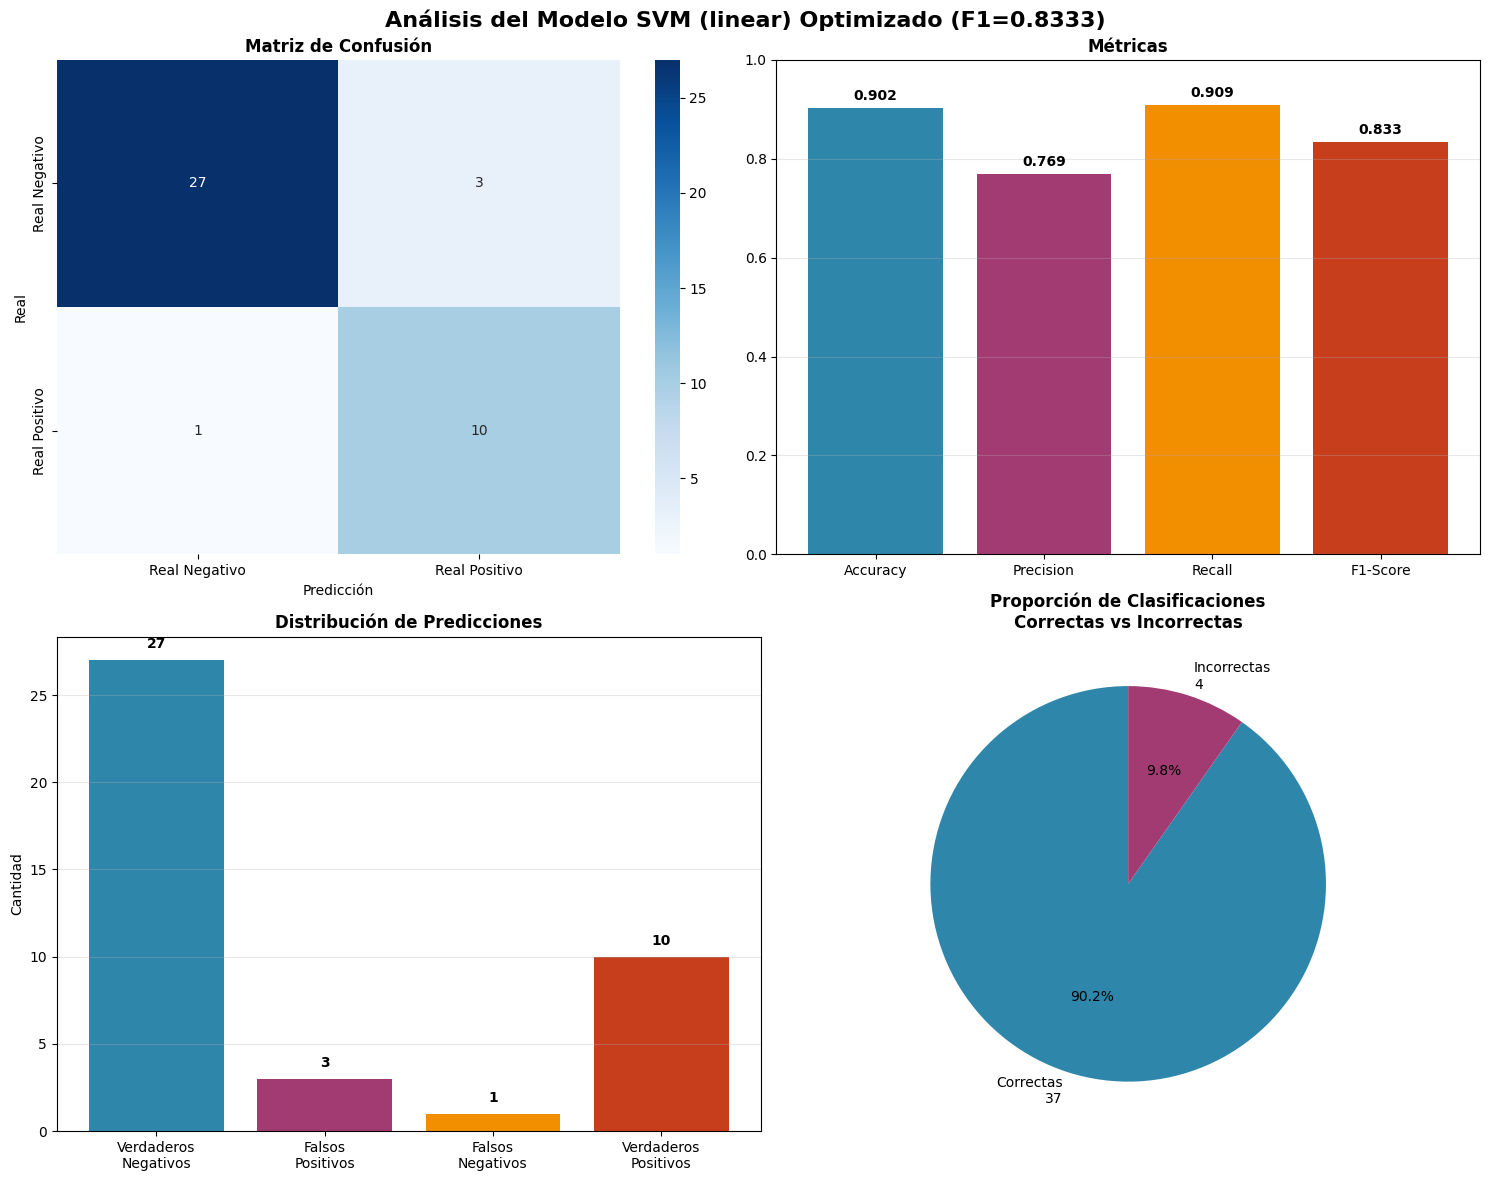

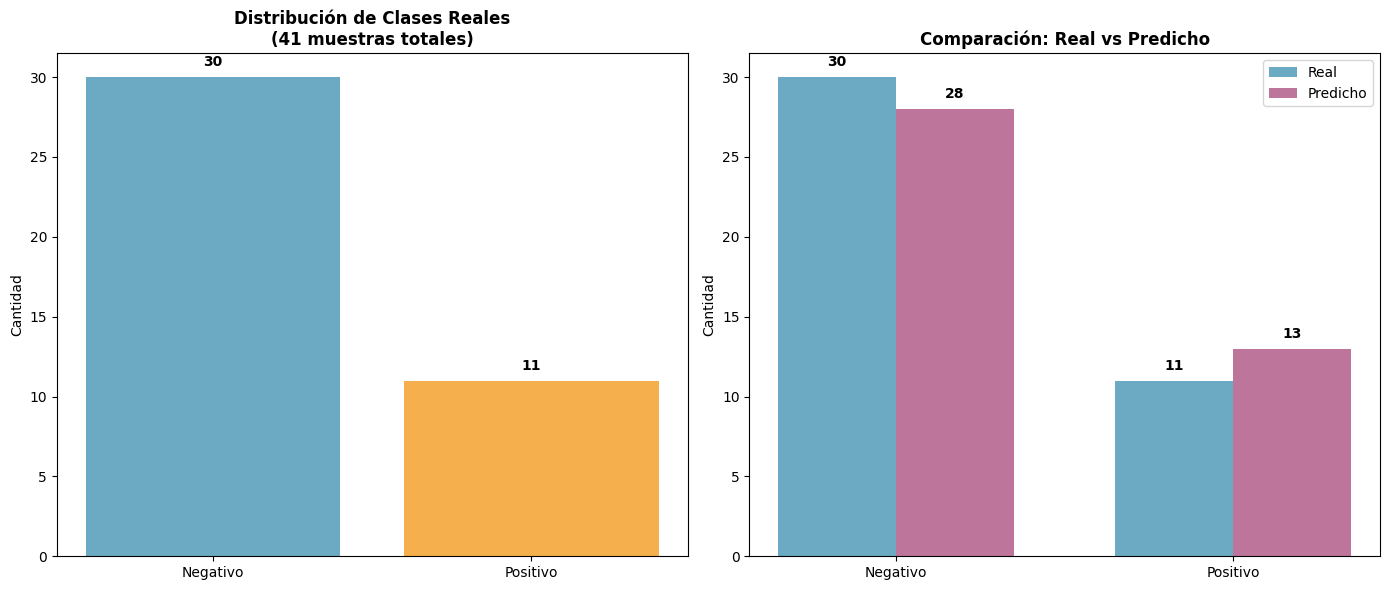

RESUMEN DEL MODELO SVM (linear)
üìä Total de muestras: 41
‚≠ê F1-Score: 0.8333
üìà Accuracy: 0.902
üéØ Precision: 0.769
üîç Recall: 0.909
‚úÖ Verdaderos Positivos: 10
‚úÖ Verdaderos Negativos: 27
‚ùå Falsos Positivos: 3
‚ùå Falsos Negativos: 1
üìä Proporci√≥n correctas: 90.2%


In [ ]:

# Predicciones con el mejor modelo encontrado
best_model = KernelSVM(
    C=best_params['C'],
    kernel=best_kernel,
    gamma=best_params['gamma'] if best_kernel != 'linear' else 1.0,
    degree=best_params['degree'] if best_kernel == 'poly' else 3,
    n_iters=best_params['n_iters']
)

best_model.fit(X_train, y_train)
preds = best_model.predict(X_val)

# Matriz de confusi√≥n
cm = confusion_matrix(y_val, preds)
tn, fp, fn, tp = cm.ravel()

# M√©tricas
accuracy = (tp + tn) / cm.sum()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = f1_score_SVM(y_val, preds)  # tu funci√≥n personalizada

plt.style.use('default')
sns.set_palette("husl")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'An√°lisis del Modelo SVM ({best_kernel}) Optimizado (F1={f1:.4f})',
             fontsize=16, fontweight='bold')

# Heatmap de matriz de confusi√≥n
labels = ['Real Negativo', 'Real Positivo']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title('Matriz de Confusi√≥n', fontweight='bold')
ax1.set_xlabel('Predicci√≥n')
ax1.set_ylabel('Real')

# Gr√°fico de barras de m√©tricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
bars = ax2.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
ax2.set_title('M√©tricas', fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for bar, value in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2., value + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Distribuci√≥n de predicciones
categories = ['Verdaderos\nNegativos', 'Falsos\nPositivos', 'Falsos\nNegativos', 'Verdaderos\nPositivos']
counts = [tn, fp, fn, tp]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
ax3.bar(categories, counts, color=colors)
ax3.set_title('Distribuci√≥n de Predicciones', fontweight='bold')
ax3.set_ylabel('Cantidad')
ax3.grid(axis='y', alpha=0.3)
for i, count in enumerate(counts):
    ax3.text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart correctas vs incorrectas
correct_predictions = tn + tp
incorrect_predictions = fp + fn
sizes = [correct_predictions, incorrect_predictions]
labels_pie = [f'Correctas\n{correct_predictions}', f'Incorrectas\n{incorrect_predictions}']
colors_pie = ['#2E86AB', '#A23B72']
ax4.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax4.set_title('Proporci√≥n de Clasificaciones\nCorrectas vs Incorrectas', fontweight='bold')

plt.tight_layout()
plt.show()

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(14, 6))

# Distribuci√≥n de clases reales
real_classes = ['Negativo', 'Positivo']
real_counts = [tn + fp, fn + tp]
ax5.bar(real_classes, real_counts, color=['#2E86AB', '#F18F01'], alpha=0.7)
ax5.set_title(f'Distribuci√≥n de Clases Reales\n({cm.sum()} muestras totales)', fontweight='bold')
ax5.set_ylabel('Cantidad')
for i, count in enumerate(real_counts):
    ax5.text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

# Distribuci√≥n predicho vs real
width = 0.35
x = np.arange(len(real_classes))
real_bars = ax6.bar(x - width/2, real_counts, width, label='Real', color='#2E86AB', alpha=0.7)
pred_bars = ax6.bar(x + width/2, [tn + fn, fp + tp], width, label='Predicho', color='#A23B72', alpha=0.7)
ax6.set_title('Comparaci√≥n: Real vs Predicho', fontweight='bold')
ax6.set_ylabel('Cantidad')
ax6.set_xticks(x)
ax6.set_xticklabels(real_classes)
ax6.legend()
for bar in real_bars + pred_bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             str(int(height)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("="*50)
print(f"RESUMEN DEL MODELO SVM ({best_kernel})")
print("="*50)
print(f"üìä Total de muestras: {cm.sum()}")
print(f"‚≠ê F1-Score: {f1:.4f}")
print(f"üìà Accuracy: {accuracy:.3f}")
print(f"üéØ Precision: {precision:.3f}")
print(f"üîç Recall: {recall:.3f}")
print(f"‚úÖ Verdaderos Positivos: {tp}")
print(f"‚úÖ Verdaderos Negativos: {tn}")
print(f"‚ùå Falsos Positivos: {fp}")
print(f"‚ùå Falsos Negativos: {fn}")
print(f"üìä Proporci√≥n correctas: {(tp+tn)/cm.sum():.1%}")
print("="*50)
